In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tweepy
import time
import seaborn as sns
import random
import csv

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys. 
consumer_key = "VqVeaA0kyQ1yrEuwXa8rQMN16"
consumer_secret = "rUmN2YcBMFRd1epdH6Zrpg1lunMjchrF6S1kNWfOlfb27Aye43"
access_token = "441203605-dqCCiQBvFzuoJSjJG0PTc0Xj0uxGKPa1E1x1NgHo"
access_token_secret = "F4UFSf6SseVV6DChRy7OAoCZ3ZMaLQqZYC2wZnO2b8ntJ"

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Target Search Term
target_user = ("@BreitbartNews", 
               "@TheOnion", 
               "@CNN",
               "@FoxNews", 
               "@BBCWorld", 
               "@nytimes", 
               "@CBSNews")

# Array to hold sentiment
sentiment_array = []

# Loop through all target users
for target in target_user:

    # Variables for holding sentiments
    counter = 1
    user = []
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    decision_list = []
    
    # Loop through x times (total of 100 tweets)
    for x in range(5):

        # Run search around each tweet
        tweets = api.user_timeline(target, page = x+1)

        # Loop through all tweets
        for tweet in tweets:

                # Run Vader Analysis on each tweet
                compound = analyzer.polarity_scores(tweet["text"])["compound"]
                pos = analyzer.polarity_scores(tweet["text"])["pos"]
                neu = analyzer.polarity_scores(tweet["text"])["neu"]
                neg = analyzer.polarity_scores(tweet["text"])["neg"]
                if compound < 0:
                    decision = 0-1
                else:
                    if pos > neu:
                        decision = 1
                    else:
                        decision = 0
                
                # Add each value to the appropriate array
                user.append(target)
                compound_list.append(compound)
                positive_list.append(pos)
                negative_list.append(neg)
                neutral_list.append(neu)
                decision_list.append(decision)
                
                sentiment_array.append({"User":target,
                                "Date": tweet["created_at"],
                                "Tweet":tweet["text"],
                                "Compound": compound,
                                "Positive": pos,
                                "Negative": neu,
                                "Neutral": neg,
                                "Tweets Ago": counter})
                counter = counter + 1
    
    # Store the Average Sentiments
    try:    
        sentiment = {"User": target,
                     "Compound": np.mean(compound_list),
                     "Positive": np.mean(positive_list),
                     "Neutral": np.mean(negative_list),
                     "Negative": np.mean(neutral_list),
                     "Decision": np.sum(decision_list),
                     "Tweet Count": len(compound_list)}
        print(sentiment)
        print("")

    except:
        print("Skipping bad data")
        continue
        

#convert sentiment_array into dataframe
sentiments_pd = pd.DataFrame.from_dict(sentiment_array)

{'User': '@BreitbartNews', 'Compound': 0.032598999999999996, 'Positive': 0.080990000000000006, 'Neutral': 0.044260000000000001, 'Negative': 0.87474999999999992, 'Decision': -15, 'Tweet Count': 100}

{'User': '@TheOnion', 'Compound': 0.026690000000000005, 'Positive': 0.075420000000000001, 'Neutral': 0.073099999999999998, 'Negative': 0.85149999999999992, 'Decision': -26, 'Tweet Count': 100}

{'User': '@CNN', 'Compound': -0.061739000000000023, 'Positive': 0.061090000000000005, 'Neutral': 0.081640000000000018, 'Negative': 0.85727000000000009, 'Decision': -39, 'Tweet Count': 100}

{'User': '@FoxNews', 'Compound': -0.0030990000000000002, 'Positive': 0.073109999999999994, 'Neutral': 0.078299999999999995, 'Negative': 0.84857999999999989, 'Decision': -30, 'Tweet Count': 100}

{'User': '@BBCWorld', 'Compound': -0.132049, 'Positive': 0.050460000000000005, 'Neutral': 0.13039000000000001, 'Negative': 0.81913999999999987, 'Decision': -39, 'Tweet Count': 100}

{'User': '@nytimes', 'Compound': -0.0540

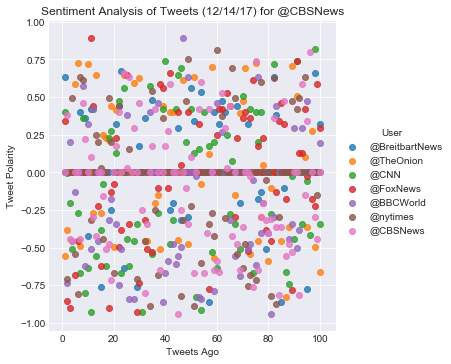

In [9]:
sns.lmplot(x = "Tweets Ago", y = "Compound", data = sentiments_pd, fit_reg = False, hue = "User", legend = True)
sns.set_style("dark")
plt.title("Sentiment Analysis of Tweets (%s) for %s" % (time.strftime("%x"), target))
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.grid()
plt.savefig('scatter.png', bbox_inches='tight')
plt.show()

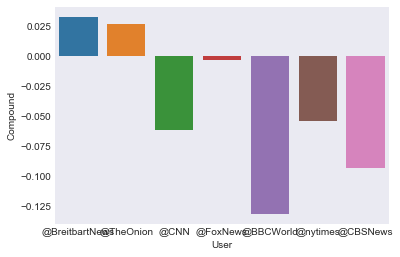

In [8]:
compound_avg = pd.DataFrame(sentiments_pd.groupby("User").mean()["Compound"], index = None).reset_index()

sns.barplot(x = "User", y = "Compound", data = sentiments_pd, ci = 0)
plt.title("Average Compound Sentiment Score by News Source")
plt.savefig('barChart.png')
plt.show()

In [5]:
print(compound_avg)
print("The overall average sentiment score for the last 100 tweets, for each news source, is: %s" % round(sentiments_pd["Compound"].mean(),6))

             User  Compound
0       @BBCWorld -0.132049
1  @BreitbartNews  0.032599
2        @CBSNews -0.093108
3            @CNN -0.061739
4        @FoxNews -0.003099
5       @TheOnion  0.026690
6        @nytimes -0.054049
The overall average sentiment score for the last 100 tweets, for each news source, is: -0.040679


In [11]:
sentiments_pd.to_csv('sentiments.csv', sep=',')

In [6]:
#Three observable trends
#1 - There are many tweets with a compound of 0, this is due to tweets only containing a link to an article, a picture, or having few words to analyze. It is recommended that these are filtered out for a true sentiment score.
#2 - It was interesting to see that the only positive compound scores came from the satirycal site, The Onion, and the hate filled, Breitbart news. But this could be that they use snarky sarcasm in their tweets.
#3 - Surprisingly Fox News was also towards neutral to positive as they also tend to report news that is hateful, but it could be the way that they word it as well. 